# An introduction to Deep Lifelong Learning 

## Abstract
Lifelong Learning is an area of growing research interest and successfully achieving Lifelong Learning is an essential hurdle to overcome to achieve systems which can imitate the human brain. Lifelong Learning is the ability to learn multiple tasks sequentially without losing the ability to complete the previous tasks. This tutorial introduces Lifelong Learning, it then moves onto approaches to Lifelong Learning in deep learning systems with a particular focus on Elastic Weight Consolidation and Replay, and their implementations in PyTorch applied to the MNIST dataset and how they perform relative to a Naive Benchmark.

## Pre-requisites
Understanding of Backpropagation and Convolutional Neural Networks (CNN's) and their implementation in PyTorch is assumed

## Contents
1. Learning Objectives
2. Differences with pre-existing materials
3. Lifelong Learning Concepts (inc. Definition, Differences to Multitask Learning, Significance)
4. Modern Approaches to Lifelong Learning in Neural Networks
5. This Tutorial
6. Basic Code (inc. Data Preparation, CNN, Optimization)
7. Naive Approach
8. Replay
9. Elastic Weight Consolidation
10. References

## Learning Objectives
- Develop an understanding of what Lifelong Learning is, its differences to Multi-Task Learning, its importance in developing advanced Machine Learning systems and challenges faced when developing Lifelong Learning systems.
- Discuss modern approaches to Lifelong Learning
- Introduce Elastic Weight Consolidation and Replay and inform how they can be implemented in PyTorch 
- Consider how changing various hyperparameters can affect the performance of the above algorithms and the resulting tradeoffs

## Differences with pre-existing materials
Due to the relative novelty of Lifelong Learning research there is somewhat of a lack of introductory resources. I've found that most tutorials are high level and so direct you to papers to understand the algorithms, theoretical, and highly mathematical. I've aimed for a tutorial which gives a solid overview of the field followed by a particular focus on 2 key algorithms using a highly practical approach. Where possible I have attempted to avoid complex maths and instead explain what is happening in the code. 
- **Pro** Practical Approach to Lifelong Learning
- **Pro** Relatively complete overview of the field
- **Pro** No complex maths
- **Con** For a deeper understanding more maths is required
- **Con** Due to the different strengths of different lifelong learning algorithms a comparison using multiple applications may be helpful

## Lifelong Learning Concepts
### Definition
Lifelong Learning is the ability for a Machine Learning model to learn multiple tasks sequentially without forgetting previously learned tasks. More formally, \
"*The learner has performed learning on a sequence of tasks, from t1 to t(n-1). When faced with the nth task, it uses the relevant knowledge gained in the past n-1 tasks to help learning for the nth task.*" [from Lifelong Machine Learning in the Big Data Era by Chen & Liu]
### Differences to Multitask Learning
"*Multitask Learning: Multitask Learning: Giving a set of learning tasks, t1 , t2 , …, t(n), co-learn all tasks simultaneously.*" [from Lifelong Machine Learning in the Big Data Era by Chen & Liu] \
From the definition the difference between Multitask and Lifelong Learning is clear - learning sequentially vs simultaneously. Multitask learning is usually regarded as an upper bound for Lifelong Learning.
### Significance
Humans (and other animals) are outstanding at learning millions of tasks throughout our lives without forgetting how to do tasks we learned previously. In neuroscience the ability to learn new tasks is referred to as Neuro-Plasticity and the ability to remember previously learned tasks is referred to as Neuro-Stability. \
On the other hand Machine Learning systems, including Neural Networks, are prone to forgetting previously learned tasks as the new tasks interfere with previously learned knowledge. This can lead to an abrupt performance decrease or even the old knowledge being overwritten completely (a demonstration of this later). This is known as **Catastrophic Forgetting**.\
Although workarounds are possible, for example, training an individual system on each task or retraining the system each time a task (new or previously seen) is encountered, these approaches would be incredibly expensive and thus unviable.

## Modern approaches to Lifelong Learning in Neural Networks
Approaches to Lifelong Learning in Neural Networks can be classified into 3 categories:
1. Regularisation
2. Dynamic Architectures
3. Replay

### 1. Regularisation
Regularisation approaches mitigate Catastrophic Forgetting by constraining the updates of weights in Neural Networks. These algorithms estimate the importance of weights to previously learned tasks and slow down the changes to the most important weights therby selectively reducing the network's plasticity and improving stability. Regularisation based approaches are typically inspired by theoretical neuroscience models and require less storage relative to replay and dynamic architecture approaches. 
\
Notable Regularisation methods include:
- Elastic Weight Consolidation: A technique that adds a quadratic penalty term to the loss function based on the Fisher Information Matrix
- Synaptic Intelligence: The importance of each weight is accumulated over time during learning. This information is used to constraight weight updates.
### 2. Dynamic Architectures
These approaches propose changing the architectural properties of networks in response to new rasks by dynamically accomodating novel neural resources e.g. re-training with more layers. \
An example of this is *progressive networks* where a pool of pre-trained models are stored (one for each task). Lateral connections exist between each neurak network to transfer previously learned knowledge to a new task without altering the previous network. \
A clear downside is the space required to store expanding networks and the complexity of the models these approaches can produce. These approaches are often used in conjuction with Regularisation approaches.
![alt text](DynamicallyExpandingNetworks.png "Dynamically Expanding Networks")
### 3. Replay
Replay methods expose the model to both new data and data on which it has already been trained. The data is shuffled to interleve past task data with the current task data.

## This Tutorial
In this tutorial I will be using the MNIST dataset. \
I have separated the data into 5 classification tasks as below (from Three scenarios for continual learning by Ven & Tolias)
![alt text](Tasks.png "The 5 Tasks")
This is a common Lifelong Learning benchmark \
I start by testing a Naive approach using a CNN trained on each task consecutively, I then apply Elastic Weight Consolodation to the CNN, finally I attempt a basic Replay method using the CNN   
Throughout the tutorial I'll refer to each task using the numbers being classified eg the first task is task_01

## Basic Code

In [677]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

### Data Preparation 

In [731]:
# Download MNIST training and test data from open datasets
# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Split the training and test data into the 5 subsets. First get the indicies of the target data points, then save the data points associated with these indices. 

In [736]:
# Split training data
training_indices_01 = (training_data.targets == 0) | (training_data.targets == 1)
training_group_01 = torch.utils.data.Subset(training_data, torch.where(training_indices_01)[0])
training_indices_23 = (training_data.targets == 2) | (training_data.targets == 3)
training_group_23 = torch.utils.data.Subset(training_data, torch.where(training_indices_23)[0])
training_indices_45 = (training_data.targets == 4) | (training_data.targets == 5)
training_group_45 = torch.utils.data.Subset(training_data, torch.where(training_indices_45)[0])
training_indices_67 = (training_data.targets == 6) | (training_data.targets == 7)
training_group_67 = torch.utils.data.Subset(training_data, torch.where(training_indices_67)[0])
training_indices_89 = (training_data.targets == 8) | (training_data.targets == 9)
training_group_89 = torch.utils.data.Subset(training_data, torch.where(training_indices_89)[0])

# Split test data
test_indices_01 = (test_data.targets == 0) | (test_data.targets == 1)
test_group_01 = torch.utils.data.Subset(test_data, torch.where(test_indices_01)[0])
test_indices_23 = (test_data.targets == 2) | (test_data.targets == 3)
test_group_23 = torch.utils.data.Subset(test_data, torch.where(test_indices_23)[0])
test_indices_45 = (test_data.targets == 4) | (test_data.targets == 5)
test_group_45 = torch.utils.data.Subset(test_data, torch.where(test_indices_45)[0])
test_indices_67 = (test_data.targets == 6) | (test_data.targets == 7)
test_group_67 = torch.utils.data.Subset(test_data, torch.where(test_indices_67)[0])
test_indices_89 = (test_data.targets == 8) | (test_data.targets == 9)
test_group_89 = torch.utils.data.Subset(test_data, torch.where(test_indices_89)[0])

print("Number of training samples labeled as 0 or 1:", len(training_group_01))
print("Number of training samples labeled as 2 or 3:", len(training_group_23))
print("Number of training samples labeled as 4 or 5:", len(training_group_45))
print("Number of training samples labeled as 6 or 7:", len(training_group_67))
print("Number of training samples labeled as 8 or 9:", len(training_group_89))

Number of training samples labeled as 0 or 1: 12665
Number of training samples labeled as 2 or 3: 12089
Number of training samples labeled as 4 or 5: 11263
Number of training samples labeled as 6 or 7: 12183
Number of training samples labeled as 8 or 9: 11800


Create the DataLoader for each subset with a batch size of 64

In [737]:
batch_size = 64

# Create data loaders.
train_dataloader_01 = DataLoader(training_group_01, batch_size=batch_size)
test_dataloader_01 = DataLoader(test_group_01, batch_size=batch_size)
train_dataloader_23 = DataLoader(training_group_23, batch_size=batch_size)
test_dataloader_23 = DataLoader(test_group_23, batch_size=batch_size)
train_dataloader_45 = DataLoader(training_group_45, batch_size=batch_size)
test_dataloader_45 = DataLoader(test_group_45, batch_size=batch_size)
train_dataloader_67 = DataLoader(training_group_67, batch_size=batch_size)
test_dataloader_67 = DataLoader(test_group_67, batch_size=batch_size)
train_dataloader_89 = DataLoader(training_group_89, batch_size=batch_size)
test_dataloader_89 = DataLoader(test_group_89, batch_size=batch_size)

### Define the CNN
Here I define a very basic CNN with 2 Convolutional Layers, 1 pooling layer and 3 fully connected layers. I'm using relu as the activation function.

In [795]:
# Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,28)
        self.pool = nn.MaxPool2d(1, 1)
        self.conv2 = nn.Conv2d(64, 16, 1)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
model = CNN()

In [796]:
print(model)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(28, 28), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Optimisation
Here I define the loss function, Cross Entropy Loss, and an Optimizer, Stochastic Gradient Descent. This is where some Hyperparameters can be changed.

In [797]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [798]:
def train(dataloader, model, loss_fn, optimizer):
    for epoch in range(2):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # split the data into inputs and labels
            inputs, labels = data
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward pass
            outputs = model(inputs)
            # backwards pass
            loss = loss_fn(outputs, labels)
            loss.backward()
            # optimise - go down the error function
            optimizer.step()    
    print('Finished!')

### Testing

In [799]:
def test(dataloader, model, name):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # calculate outputs by doing a forward pass w/ test data
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(name)
            #print('Predicted: ')
            #print(predicted)
            #print('Labels')
            #print(labels)
    print(f'Accuracy of the network on the {name} test images: {100 * correct // total} %')
    return 100 * correct // total

## Naive Approach
Here I use a Naive approach to Lifelong Learning - retraining the model with each new task. \
Looking at the results of the test data it is clear Catastrophic Forgetting is occuring as the accuracy on previous tasks falls to 0 immediately. The graphs below may be useful in showing the extent of this more visually. 

In [800]:
task1_acc = []
task2_acc = []
task3_acc = []
task4_acc = []
task5_acc = []

# Train each task sequentially. Calculate the error for that task and each previous task
# Here we demonstrate a Naive approach to Lifelong Learning - retraining a model with each task
# Task 01
train(train_dataloader_01, model, loss_fn, optimizer)
task1_acc.append(test(test_dataloader_01, model, '01'))
# Task 23
train(train_dataloader_23, model, loss_fn, optimizer)
task2_acc.append(test(test_dataloader_23, model, '23'))
task1_acc.append(test(test_dataloader_01, model, '01'))
# Task 45
train(train_dataloader_45, model, loss_fn, optimizer)
task3_acc.append(test(test_dataloader_45, model, '45'))
task1_acc.append(test(test_dataloader_01, model, '01'))
task2_acc.append(test(test_dataloader_23, model, '23'))
# Task 67
train(train_dataloader_67, model, loss_fn, optimizer)
task4_acc.append(test(test_dataloader_67, model, '67'))
task1_acc.append(test(test_dataloader_01, model, '01'))
task2_acc.append(test(test_dataloader_23, model, '23'))
task3_acc.append(test(test_dataloader_45, model, '45'))
# Task 89
train(train_dataloader_89, model, loss_fn, optimizer)
task5_acc.append(test(test_dataloader_89, model, '89'))
task1_acc.append(test(test_dataloader_01, model, '01'))
task2_acc.append(test(test_dataloader_23, model, '23'))
task3_acc.append(test(test_dataloader_45, model, '45'))
task4_acc.append(test(test_dataloader_67, model, '67'))

Finished!
Accuracy of the network on the 01 test images: 99 %
Finished!
Accuracy of the network on the 23 test images: 97 %
Accuracy of the network on the 01 test images: 0 %
Finished!
Accuracy of the network on the 45 test images: 98 %
Accuracy of the network on the 01 test images: 0 %
Accuracy of the network on the 23 test images: 0 %
Finished!
Accuracy of the network on the 67 test images: 99 %
Accuracy of the network on the 01 test images: 0 %
Accuracy of the network on the 23 test images: 0 %
Accuracy of the network on the 45 test images: 0 %
Finished!
Accuracy of the network on the 89 test images: 94 %
Accuracy of the network on the 01 test images: 0 %
Accuracy of the network on the 23 test images: 0 %
Accuracy of the network on the 45 test images: 0 %
Accuracy of the network on the 67 test images: 0 %


18.8


([<matplotlib.axis.XTick at 0x2ab509970>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

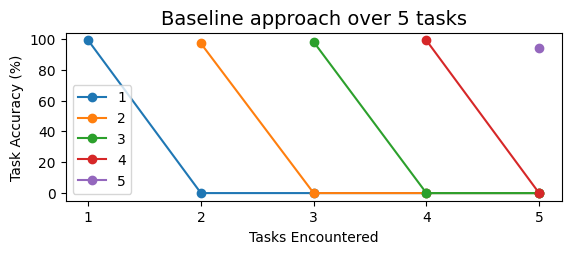

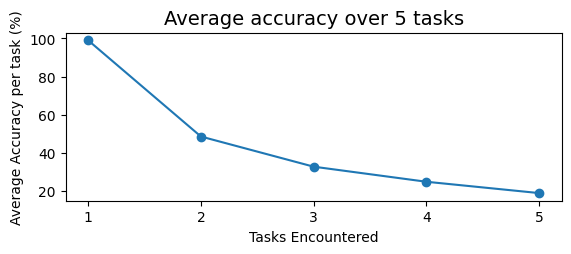

In [805]:
plt.figure(1)
plt.subplot(211)
# Graph of accuracy per task over time
plt.plot([1,2,3,4,5], task1_acc, '-o', label="1")
plt.plot([2,3,4,5], task2_acc, '-o', label="2")
plt.plot([3,4,5], task3_acc, '-o', label="3")
plt.plot([4,5], task4_acc, '-o', label="4")
plt.plot([5], task5_acc, '-o', label="5")
plt.xlabel('Tasks Encountered', fontsize=10)
plt.ylabel('Task Accuracy (%)', fontsize=10)
plt.title('Baseline approach over 5 tasks', fontsize=14);
plt.xticks([1, 2, 3, 4, 5])
plt.legend()

plt.figure(2)
plt.subplot(212)
# Graph of average accuracy
task1_avg = task1_acc[0]
task2_avg = (task1_acc[1] + task2_acc[0])/2
task3_avg = (task1_acc[2] + task2_acc[1] + task3_acc[0])/3
task4_avg = (task1_acc[3] + task2_acc[2] + task3_acc[1] + task4_acc[0])/4
task5_avg = (task1_acc[4] + task2_acc[3] + task3_acc[2] + task4_acc[1] + task5_acc[0])/5

plt.plot([1, 2, 3, 4, 5], [task1_avg, task2_avg, task3_avg, task4_avg, task5_avg], '-o')
plt.title('Average accuracy over 5 tasks', fontsize=14);
plt.xlabel('Tasks Encountered', fontsize=10)
plt.ylabel('Average Accuracy per task (%)', fontsize=10)
plt.xticks([1, 2, 3, 4, 5])

## Memory Replay 
Here I demonstrate a very simple approach to Memory Replay. \
A sample of the images and their labels from the previous tasks is interleaved into each task. \
A high level overview is as follows:
1. Images and their labels are stored in numpy arrays organised by task
2. For all tasks T<sub>n</sub>, where n>0, the images and labels from that task are concatenated with a slice of data from all the previous tasks, the size of the slice is a possible hyperparameter.
3. The concatenated numpy arrays are converted to a custom Dataset type which extends the build in PyTorch Dataset.
4. The Datasets are saved into DataLoaders and shuffled.
5. The CNN model is trained on each task sequentially with the training data for all tasks containing a slice of data from any previous tasks.

In [776]:
# Convert 01 to np array
images01 = []
labels01 = []
for image,label in training_group_01:
    images01.append(image.numpy())
    labels01.append(label)
images01_np = np.array(images01)
labels01_np = np.array(labels01)

# Convert 23 to np array and concat w/ 01
images23 = []
labels23 = []
for image,label in training_group_23:
    images23.append(image.numpy())
    labels23.append(label)
images23_np = np.array(images23)
labels23_np = np.array(labels23)
concat_images_03 = np.concatenate((images01_np[0:1000], images23_np))
concat_labels_03 = np.concatenate((labels01_np[0:1000], labels23_np))

# Convert 45 to np array and concat w/ 03
images45 = []
labels45 = []
for image,label in training_group_45:
    images45.append(image.numpy())
    labels45.append(label)
images45_np = np.array(images45)
labels45_np = np.array(labels45)
concat_images_05 = np.concatenate((images01_np[0:1000], images23_np[0:1000], images45_np))
concat_labels_05 = np.concatenate((labels01_np[0:1000], labels23_np[0:1000], labels45_np))

# Convert 67 to np array and concat w/ 05
images67 = []
labels67 = []
for image,label in training_group_67:
    images67.append(image.numpy())
    labels67.append(label)
images67_np = np.array(images67)
labels67_np = np.array(labels67)
concat_images_07 = np.concatenate((images01_np[0:1000], images23_np[0:1000], images45_np[0:1000], images67_np))
concat_labels_07 = np.concatenate((labels01_np[0:1000],labels23_np[0:1000], labels45_np[0:1000], labels67_np))

# Convert 89 to np array and concat w/ 07
images89 = []
labels89 = []
for image,label in training_group_89:
    images89.append(image.numpy())
    labels89.append(label)
images89_np = np.array(images89)
labels89_np = np.array(labels89)
concat_images_09 = np.concatenate((images01_np[0:1000],images23_np[0:1000], images45_np[0:1000], images67_np[0:1000], images89_np))
concat_labels_09 = np.concatenate((labels01_np[0:1000], labels23_np[0:1000], labels45_np[0:1000], labels67_np[0:1000], labels89_np))

In [777]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [778]:
custom_dataset_03 = CustomDataset(concat_images_03, concat_labels_03)
custom_dataloader_03 = DataLoader(custom_dataset_03, batch_size=batch_size, shuffle=True)

custom_dataset_05 = CustomDataset(concat_images_05, concat_labels_05)
custom_dataloader_05 = DataLoader(custom_dataset_05, batch_size=batch_size, shuffle=True)

custom_dataset_07 = CustomDataset(concat_images_07, concat_labels_07)
custom_dataloader_07 = DataLoader(custom_dataset_07, batch_size=batch_size, shuffle=True)

custom_dataset_09 = CustomDataset(concat_images_09, concat_labels_09)
custom_dataloader_09 = DataLoader(custom_dataset_09, batch_size=batch_size, shuffle=True)

In [784]:
task1_replay_acc = []
task2_replay_acc = []
task3_replay_acc = []
task4_replay_acc = []
task5_replay_acc = []

# Train 01
train(train_dataloader_01, model, loss_fn, optimizer)
task1_replay_acc.append(test(test_dataloader_01, model, '01'))

# Train 23 w/ 01 replayed 
train(custom_dataloader_03, model, loss_fn, optimizer)
task1_replay_acc.append(test(test_dataloader_01, model, '01'))
task2_replay_acc.append(test(test_dataloader_23, model, '23'))
# Train 45 w/ 01 & 23 replayed 
train(custom_dataloader_05, model, loss_fn, optimizer)
task3_replay_acc.append(test(test_dataloader_45, model, '45'))
task1_replay_acc.append(test(test_dataloader_01, model, '01'))
task2_replay_acc.append(test(test_dataloader_23, model, '23'))
# Train 67 w/ 01, 23 & 45 replayed 
train(custom_dataloader_07, model, loss_fn, optimizer)
task4_replay_acc.append(test(test_dataloader_67, model, '67'))
task1_replay_acc.append(test(test_dataloader_01, model, '01'))
task2_replay_acc.append(test(test_dataloader_23, model, '23'))
task3_replay_acc.append(test(test_dataloader_45, model, '45'))
# Train 89 w/ 01, 23, 45, 67 & 89 replayed 
train(custom_dataloader_09, model, loss_fn, optimizer)
task5_replay_acc.append(test(test_dataloader_89, model, '89'))
task1_replay_acc.append(test(test_dataloader_01, model, '01'))
task2_replay_acc.append(test(test_dataloader_23, model, '23'))
task3_replay_acc.append(test(test_dataloader_45, model, '45'))
task4_replay_acc.append(test(test_dataloader_67, model, '67'))

Finished!
Accuracy of the network on the 01 test images: 99 %
Finished!
Accuracy of the network on the 01 test images: 95 %
Accuracy of the network on the 23 test images: 98 %
Finished!
Accuracy of the network on the 45 test images: 98 %
Accuracy of the network on the 01 test images: 94 %
Accuracy of the network on the 23 test images: 79 %
Finished!
Accuracy of the network on the 67 test images: 97 %
Accuracy of the network on the 01 test images: 95 %
Accuracy of the network on the 23 test images: 85 %
Accuracy of the network on the 45 test images: 89 %
Finished!
Accuracy of the network on the 89 test images: 96 %
Accuracy of the network on the 01 test images: 94 %
Accuracy of the network on the 23 test images: 79 %
Accuracy of the network on the 45 test images: 80 %
Accuracy of the network on the 67 test images: 85 %


86.8


([<matplotlib.axis.XTick at 0x2ab41acd0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

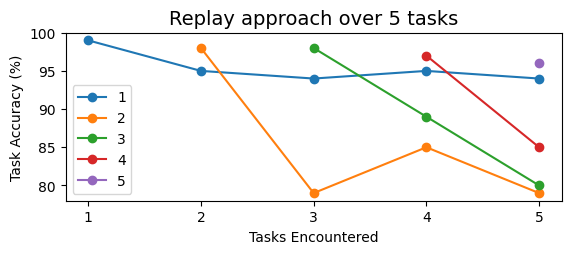

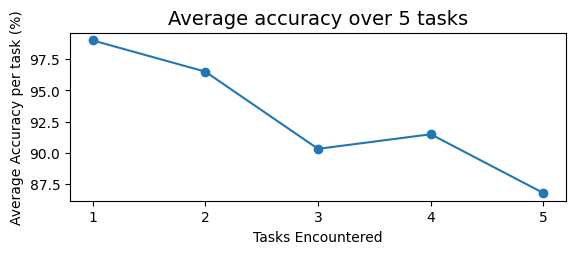

In [804]:
plt.figure(3)
plt.subplot(211)
# Graph of accuracy per task over time
plt.plot([1,2,3,4,5], task1_replay_acc, '-o', label="1")
plt.plot([2,3,4,5], task2_replay_acc, '-o', label="2")
plt.plot([3,4,5], task3_replay_acc, '-o', label="3")
plt.plot([4,5], task4_replay_acc, '-o', label="4")
plt.plot([5], task5_replay_acc, '-o', label="5")
plt.xlabel('Tasks Encountered', fontsize=10)
plt.ylabel('Task Accuracy (%)', fontsize=10)
plt.title('Replay approach over 5 tasks', fontsize=14);
plt.xticks([1, 2, 3, 4, 5])
plt.legend()

plt.figure(4)
plt.subplot(212)
# Graph of average accuracy
task1_replay_avg = task1_replay_acc[0]
task2_replay_avg = (task1_replay_acc[1] + task2_replay_acc[0])/2
task3_replay_avg = (task1_replay_acc[2] + task2_replay_acc[1] + task3_replay_acc[0])/3
task4_replay_avg = (task1_replay_acc[3] + task2_replay_acc[2] + task3_replay_acc[1] + task4_replay_acc[0])/4
task5_replay_avg = (task1_replay_acc[4] + task2_replay_acc[3] + task3_replay_acc[2] + task4_replay_acc[1] + task5_replay_acc[0])/5

plt.plot([1, 2, 3, 4, 5], [task1_replay_avg, task2_replay_avg, task3_replay_avg, task4_replay_avg, task5_replay_avg], '-o')
plt.title('Average accuracy over 5 tasks', fontsize=14);
plt.xlabel('Tasks Encountered', fontsize=10)
plt.ylabel('Average Accuracy per task (%)', fontsize=10)
plt.xticks([1, 2, 3, 4, 5])

## Elastic Weight Consolidation 
Elastic Weight Consolidation (EWC) is a Regularisation technique developed in 2017 by DeepMind. In recent years it has proven to be a highly effective approach to Lifelong Learning. EWC was inspired by how our brains maintain neuro-stability whilst also being highly plastic and thus provides a very interesting approach to this topic. 
### Biological Justification
"In brains, synaptic consolidation enables continual learning by reducing the plasticity of synapses that are vital to previously learned tasks. We implement an algorithm that performs a similar operation in artificial neural networks by constraining important parameters to stay close to their old values." - Overcoming catastrophic forgetting in neural networks, Kirkpatric et al.
### The big idea
The core of EWC is introducing a quadratic penalty term to the standard loss function. This penalty term considers the distance between the current weights and the optimal weights from the previous task. As such, EWC reduces the variance between learning new tasks and helps maintain a balance between learning new tasks and retaining old ones. \
\
![alt text](EWC.jpeg "EWC")
\
*The above image shows the training trajectory for EWC (red), considering only task B (blue) and constraining all weights uniformly (green), from Kirkpatric et al.* \
The training process is illustrated in a parameter space. Parameter regions in grey lead to good performance on Task A, cream regions lead to good perfomance in B. If standard training occurs on Task B, blue arrow, we minimize the loss of Task B but forget Task A. Alternatively, if we constrain each weight with the same coefficient, green arrow, the restriction is too severe and we can only learn Task A at the expense of Task B. EWC, red arrow, finds a solution for Task B which also performs well for Task A by computing how important weights are for Task A. \
The importance of each weight to Task A is called the Fisher Information Matrix. The Fisher Information Matrix provides an approximation of the curvature of the loss function, thus telling us how sensitve the network is to changes in the weights. Those weights should be constrained more when training on new tasks. \
The ewc_lambda is a hyperparameter that controls the strength of the EWC penalty.

In [670]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 1

This function updates the Fisher Information Matrix after training on a task. \
First it performs backpropagation (without optimizing) to accumulate gradients. \
The squared gradients are accumulated into the Fisher Information Matrix for each parameter. 

In [792]:
def update_fisher(task_id, dataloader):

    model.train()
    optimizer.zero_grad()
  
    for i, data in enumerate(dataloader, 0):      
        inputs, labels = data        
        output = model(inputs)
        loss = F.cross_entropy(output, labels)
        loss.backward()

    fisher_dict[task_id] = {}
    optpar_dict[task_id] = {}

    for name, param in model.named_parameters():
    
        optpar_dict[task_id][name] = param.data.clone()
        fisher_dict[task_id][name] = param.grad.data.clone().pow(2)


This function performs backpropagation, however, before computing the gradient of the loss function, for each previous task it computes the regularization term for the Fisher Information Matrix and the difference between the current and previous parameters values.

In [788]:
def train_ewc(model, task_id, dataloader, optimizer, epoch):
    model.train()

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data    
        optimizer.zero_grad()
        
        output = model(inputs)
        loss = loss_fn(output, labels)
        for task in range(task_id):
            for name, param in model.named_parameters():
              fisher = fisher_dict[task][name]
              optpar = optpar_dict[task][name]
              loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
        loss.backward()
        optimizer.step()

In [789]:
task1_ewc_acc = []
task2_ewc_acc = []
task3_ewc_acc = []
task4_ewc_acc = []
task5_ewc_acc = []


# 01 EWC training 
for epoch in range(0,2):
    train_ewc(model, 0, train_dataloader_01, optimizer=optimizer, epoch=epoch)
update_fisher(0, train_dataloader_01)
task1_ewc_acc.append(test(test_dataloader_01, model, '01'))

# 23 EWC training
for epoch in range(0,2):
    train_ewc(model, 1, train_dataloader_23, optimizer=optimizer, epoch=epoch)
update_fisher(1, train_dataloader_23)
task2_ewc_acc.append(test(test_dataloader_23, model, '23'))
task1_ewc_acc.append(test(test_dataloader_01, model, '01'))

# 45 EWC training
for epoch in range(0,2):
    train_ewc(model, 2, train_dataloader_45, optimizer=optimizer, epoch=epoch)
update_fisher(2, train_dataloader_45)
task3_ewc_acc.append(test(test_dataloader_45, model, '45'))
task2_ewc_acc.append(test(test_dataloader_23, model, '23'))
task1_ewc_acc.append(test(test_dataloader_01, model, '01'))

# 67 EWC training
for epoch in range(0,2):
    train_ewc(model, 3, train_dataloader_67, optimizer=optimizer, epoch=epoch)
update_fisher(3, train_dataloader_67)
task4_ewc_acc.append(test(test_dataloader_23, model, '67'))
task3_ewc_acc.append(test(test_dataloader_45, model, '45'))
task2_ewc_acc.append(test(test_dataloader_23, model, '23'))
task1_ewc_acc.append(test(test_dataloader_01, model, '01'))

# 89 EWC training
for epoch in range(0,2):
    train_ewc(model, 4, train_dataloader_89, optimizer=optimizer, epoch=epoch)
update_fisher(4, train_dataloader_89)
task5_ewc_acc.append(test(test_dataloader_23, model, '89'))
task4_ewc_acc.append(test(test_dataloader_23, model, '67'))
task3_ewc_acc.append(test(test_dataloader_45, model, '45'))
task2_ewc_acc.append(test(test_dataloader_23, model, '23'))
task1_ewc_acc.append(test(test_dataloader_01, model, '01'))

Accuracy of the network on the 01 test images: 99 %
Accuracy of the network on the 23 test images: 98 %
Accuracy of the network on the 01 test images: 22 %
Accuracy of the network on the 45 test images: 99 %
Accuracy of the network on the 23 test images: 27 %
Accuracy of the network on the 01 test images: 12 %
Accuracy of the network on the 67 test images: 11 %
Accuracy of the network on the 45 test images: 15 %
Accuracy of the network on the 23 test images: 11 %
Accuracy of the network on the 01 test images: 45 %
Accuracy of the network on the 89 test images: 17 %
Accuracy of the network on the 67 test images: 17 %
Accuracy of the network on the 45 test images: 7 %
Accuracy of the network on the 23 test images: 17 %
Accuracy of the network on the 01 test images: 25 %


([<matplotlib.axis.XTick at 0x2ab327ca0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

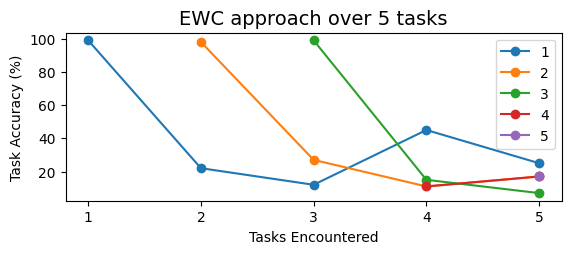

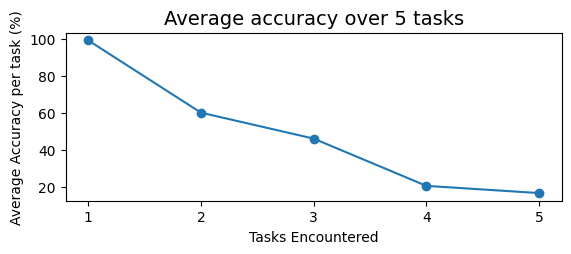

In [803]:
plt.figure(5)
plt.subplot(211)
# Graph of accuracy per task over time
plt.plot([1,2,3,4,5], task1_ewc_acc, '-o', label="1")
plt.plot([2,3,4,5], task2_ewc_acc, '-o', label="2")
plt.plot([3,4,5], task3_ewc_acc, '-o', label="3")
plt.plot([4,5], task4_ewc_acc, '-o', label="4")
plt.plot([5], task5_ewc_acc, '-o', label="5")
plt.xlabel('Tasks Encountered', fontsize=10)
plt.ylabel('Task Accuracy (%)', fontsize=10)
plt.title('EWC approach over 5 tasks', fontsize=14);
plt.xticks([1, 2, 3, 4, 5])
plt.legend()

plt.figure(6)
plt.subplot(212)
# Graph of average accuracy
task1_ewc_avg = task1_ewc_acc[0]
task2_ewc_avg = (task1_ewc_acc[1] + task2_ewc_acc[0])/2
task3_ewc_avg = (task1_ewc_acc[2] + task2_ewc_acc[1] + task3_ewc_acc[0])/3
task4_ewc_avg = (task1_ewc_acc[3] + task2_ewc_acc[2] + task3_ewc_acc[1] + task4_ewc_acc[0])/4
task5_ewc_avg = (task1_ewc_acc[4] + task2_ewc_acc[3] + task3_ewc_acc[2] + task4_ewc_acc[1] + task5_ewc_acc[0])/5


plt.plot([1, 2, 3, 4, 5], [task1_ewc_avg, task2_ewc_avg, task3_ewc_avg, task4_ewc_avg, task5_ewc_avg], '-o')
plt.title('Average accuracy over 5 tasks', fontsize=14);
plt.xlabel('Tasks Encountered', fontsize=10)
plt.ylabel('Average Accuracy per task (%)', fontsize=10)
plt.xticks([1, 2, 3, 4, 5])

## Comparing the approaches
<img src="Baseline_results.png" width="600"/>
<img src="Replay_Results.png" width="600"/>
<img src="EWC_Results.png" width="600"/>

|Approach   |Average after 5 tasks | 
| --------- | -------------------- |
|Naive      | 18.8                 |
|Replay     | 86.8                 |
|EWC        | 16.6                 |

\
After reviewing these results I think we can draw some conclusions
1. Replay appears to be the most effective approach to this task - and is indeed highly effective. Indeed this is reflected in this paper: https://arxiv.org/pdf/1904.07734v1.pdf (Class-IL)
2. Catastrophic Forgetting clearly occurs in the Naive Approach, although EWC is somewhat successful in remembering past tasks, a high level of forgetting between tasks is taking place.

## References
Farshad Noravesh, Continual Learning Series on YouTube, https://www.youtube.com/playlist?list=PLyH8drkPF8JEKpeY9MS18EM4yYkXxZGIY \
Kirkpatrick et al. Overcoming catastrophic forgetting in neural networks, https://arxiv.org/pdf/1612.00796.pdf \
Parisi et al. Continual Lifelong Learning with Neural Networks: A Review, https://arxiv.org/pdf/1802.07569.pdf \
Aliaksei Mikhailiuk, Medium Blog, https://towardsdatascience.com/deep-lifelong-learning-drawing-inspiration-from-the-human-brain-c4518a2f4fb9
\
Pytorch Training a Classifier, https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 
\
Pytorch Quickstart, https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
\
Yunzhe Wang, Overcoming Catastrophic Forgetting: A Simple Guide to Elastic Weight Consolidation, https://towardsai.net/p/machine-learning/overcoming-catastrophic-forgetting-a-simple-guide-to-elastic-weight-consolidation \
A Gentle Introduction to Continual Learning in PyTorch, https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb
